In [50]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers

from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix


In [51]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [52]:
train_img = []
train_labels = []
image_size = 150
for i in labels:
    folderPath = os.path.join('mri-data/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is None:
            pass
        else:
            img = cv2.resize(img,(image_size,image_size))
            train_img.append(img)
            train_labels.append(i)

for i in labels:
    folderPath = os.path.join('mri-data/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is None:
            pass
        else:
            img = cv2.resize(img,(image_size,image_size))
            train_img.append(img)
            train_labels.append(i)


100%|██████████| 74/74 [00:00<00:00, 381.95it/s]


In [53]:
X_train,X_test,y_train,y_test = train_test_split(train_img,train_labels, test_size=0.1,random_state=101)


In [54]:
mapping = {}
for x in range(len(labels)):
    mapping[labels[x]] = x

In [55]:
mapping

{'glioma_tumor': 0, 'no_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}

### one hot encoding

In [56]:
y_train_ohe = []

for i in y_train:
    arr = list(np.zeros(len(labels), dtype = int))
    arr[mapping[i]] = 1
    y_train_ohe.append(arr)

In [57]:
y_test_ohe = []

for i in y_test:
    arr = list(np.zeros(len(labels), dtype = int))
    arr[mapping[i]] = 1
    y_test_ohe.append(arr)

In [58]:
effNetB0 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


In [59]:
CNN_model = effNetB0.output
CNN_model = tf.keras.layers.GlobalAveragePooling2D()(CNN_model)
CNN_model = tf.keras.layers.Dropout(rate=0.5)(CNN_model)
CNN_model = tf.keras.layers.Dense(4,activation='softmax')(CNN_model)
CNN_model = tf.keras.models.Model(inputs=effNetB0.input, outputs = CNN_model)

In [71]:
summary = pd.DataFrame(CNN_model.summary())
summary.to_csv('summary.csv')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 150, 150, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_2[0][0]'

In [61]:
CNN_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy']) #use adam optimizer to improve accuracy


In [62]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [63]:
X_train = np.array(X_train)
y_train_ohe = np.array(y_train_ohe)
history = CNN_model.fit(X_train,y_train_ohe,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                        callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.8210
Epoch 1: val_accuracy improved from -inf to 0.85374, saving model to effnet.h5
83/83 [==============================] - 146s 2s/step - loss: 0.4801 - accuracy: 0.8210 - val_loss: 0.5955 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9296
Epoch 2: val_accuracy improved from 0.85374 to 0.90816, saving model to effnet.h5
83/83 [==============================] - 138s 2s/step - loss: 0.2043 - accuracy: 0.9296 - val_loss: 0.2990 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9550
Epoch 3: val_accuracy improved from 0.90816 to 0.91497, saving model to effnet.h5
83/83 [==============================] - 130s 2s/step - loss: 0.1432 - accuracy: 0.9550 - val_loss: 0.2642 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 4/12
83/83 [============================

In [72]:
CNN_model.save('MRI_CNN.keras')
CNN_model.save("MRI_CNN.h5")

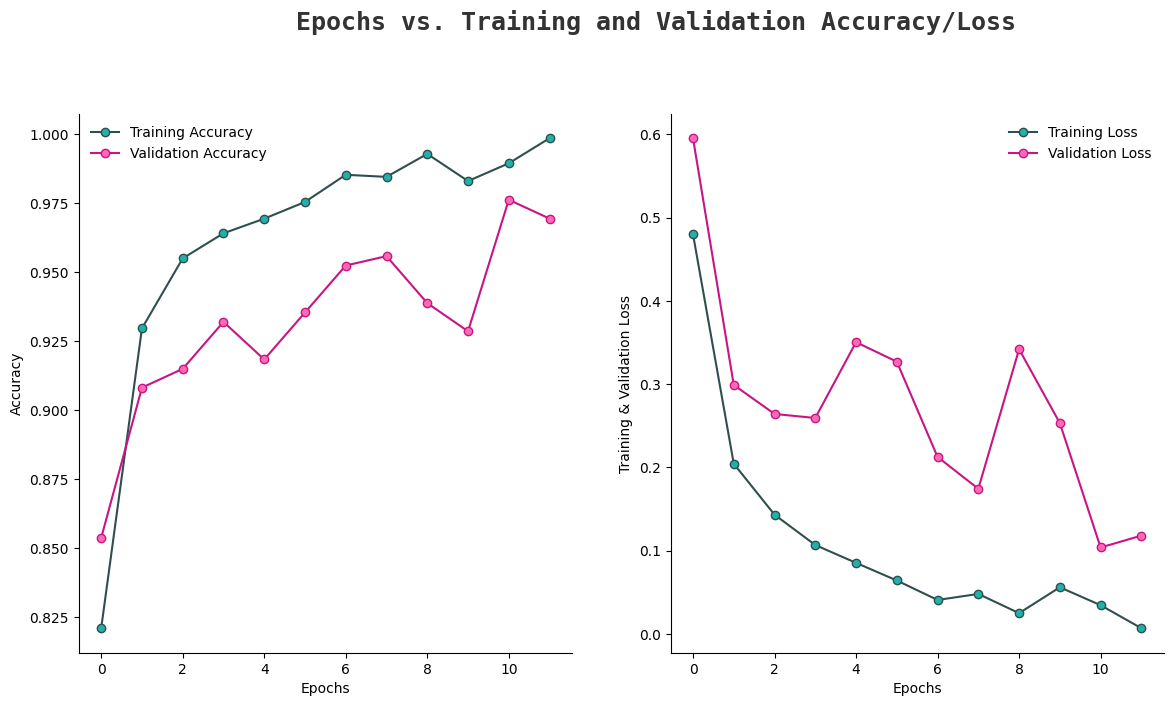

In [66]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color="black",y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor="lightseagreen",color="darkslategrey",
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor="hotpink",color="mediumvioletred",
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor="lightseagreen",color="darkslategrey",
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor="hotpink",color="mediumvioletred",
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()
fig.savefig("AccuracyLoss.png")


In [67]:
pred = CNN_model.predict(X_test, batch_size=32)  # Use an appropriate batch size
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test_ohe,axis=1)

ValueError: in user code:

    File "/Users/mnorton/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/mnorton/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        metric not in compiled_metrics
    File "/Users/mnorton/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        else:
    File "/Users/mnorton/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        if self.autotune_steps_per_execution:
    File "/Users/mnorton/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/mnorton/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 1 input(s), but it received 327 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 150, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 150, 3) dtype=uint8>]


In [68]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        97
           1       0.98      1.00      0.99        48
           2       0.94      0.97      0.96       101
           3       0.98      1.00      0.99        81

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



In [69]:
report = classification_report(y_test_new,pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('classification_report.csv')

In [75]:
np.unique(pred, return_counts=True)

(array([0, 1, 2, 3]), array([ 91,  49, 104,  83]))

In [85]:
from PIL import Image
image = cv2.imread("mri-data/Training/meningioma_tumor/m (10).jpg")
image_size = 150
image = cv2.resize(image,(image_size,image_size))
image_batch = np.expand_dims(image, axis=0)
predict = CNN_model.predict(image_batch)
np.argmax(predict,axis=1)


1/1 [==============================] - 0s 40ms/step


array([2])

In [86]:
summary = pd.read_csv("summary.csv")


,Unnamed: 0
